## Import NlTK & word tokenizer

In [1]:
#pip install spellchecker
#!pip install pyspellchecker
#pip install faiss-cpu



In [1]:
# Import necessary modules
from processing import TextTokenizer
from document import Document
from inverted_index import InvertedIndex
from csv_loader import CSVDataLoader
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from dataset import Datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import threading
import requests
from fastapi_app import FastAPIApp
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/mhamad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhamad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mhamad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mhamad/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load datasets
csv_loader1 = CSVDataLoader('lifestyle_dev/lifestyle_dev.csv', dataset_type='lifestyle_dev', delimiter='\t', nrows=1000)
csv_loader2 = CSVDataLoader('wikIR1k/documents.csv', dataset_type='wikIR1k', delimiter=',', nrows=1000)


Documents DataFrame head:
   0                                                  1
0  0  In my experience rabbits are very easy to hous...
1  1  ...rabbits can be easily trained to use a litt...
2  2  It could be a multitude of things. Lack of exe...
3  3  I've had a lot of success with crate training....
4  4  I've seen on the "Dog Whisperer" that dogs can...
Documents DataFrame head:
   id_right                                         text_right
0   1781133  it was used in landing craft during world war ...
1   2426736  after rejecting an offer from cambridge univer...
2   2224122  mat zan coached kuala lumpur fa in 1999 and wo...
3    219642  a barcode is a machine readable optical label ...
4   1728654  since the subordination of the monarchy under ...
Queries DataFrame head:
   id_left                           text_left
0   158491       southern methodist university
1     5728                             halakha
2    13554  chief justice of the united states
3    32674            

In [ ]:
strip_chars = " .!?,@/\\#~:;'\""
text_tokenizer = TextTokenizer(strip_chars, stopwords.words('english'), WordNetLemmatizer())

# Process and Clean Text Data for Dataset 1
documents1 = []
for doc in csv_loader1.docs_iter():
    cleaned_text = text_tokenizer.clean_text(doc.text)
    tokens = text_tokenizer.tokenize_text(cleaned_text)
    documents1.append(Document(doc_id=doc.doc_id, text=doc.text, tokens=tokens))

# Prepare DataFrame for Dataset 1
data1 = {
    'id': [doc.doc_id for doc in documents1],
    'text': [doc.text for doc in documents1],
    'tokens': [doc.tokens for doc in documents1]
}
df1 = pd.DataFrame(data1)
print(df1[['id', 'text', 'tokens']].head())

# Process and Clean Text Data for Dataset 2
documents2 = []
for doc in csv_loader2.docs_iter():
    cleaned_text = text_tokenizer.clean_text(doc.text)
    tokens = text_tokenizer.tokenize_text(cleaned_text)
    documents2.append(Document(doc_id=doc.doc_id, text=doc.text, tokens=tokens))

# Prepare DataFrame for Dataset 2
data2 = {
    'id': [doc.doc_id for doc in documents2],
    'text': [doc.text for doc in documents2],
    'tokens': [doc.tokens for doc in documents2]
}
df2 = pd.DataFrame(data2)
print(df2[['id', 'text', 'tokens']].head())


In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Train Doc2Vec model
tagged_data1 = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(df1['tokens'])]
tagged_data2 = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(df2['tokens'])]

max_epochs = 60
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)

model.build_vocab(tagged_data1 + tagged_data2)
# model.build_vocab( tagged_data2)

for epoch in range(max_epochs):
    print(f'iteration {epoch}')
    # model.train(tagged_data1 + tagged_data2, total_examples=model.corpus_count, epochs=model.epochs)
    model.train(tagged_data2, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

print("Model training complete.")
model.save("d2v.model")
model = Doc2Vec.load("d2v.model")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
Model training complete.


   id                                               text  cluster
0   0  In my experience rabbits are very easy to hous...        4
1   1  ...rabbits can be easily trained to use a litt...        3
2   2  It could be a multitude of things. Lack of exe...        4
3   3  I've had a lot of success with crate training....        3
4   4  I've seen on the "Dog Whisperer" that dogs can...        0
   id                                               text  \
0   0  In my experience rabbits are very easy to hous...   
1   1  ...rabbits can be easily trained to use a litt...   
2   2  It could be a multitude of things. Lack of exe...   
3   3  I've had a lot of success with crate training....   
4   4  I've seen on the "Dog Whisperer" that dogs can...   

                                          doc_vector  
0  [1.9096972, 1.1837239, 2.216872, -1.3864436, 4...  
1  [0.19345187, 0.54360324, 0.78564173, -1.959963...  
2  [0.8166514, -0.9877483, 1.1310858, 0.8674775, ...  
3  [0.76012623, 0.39853

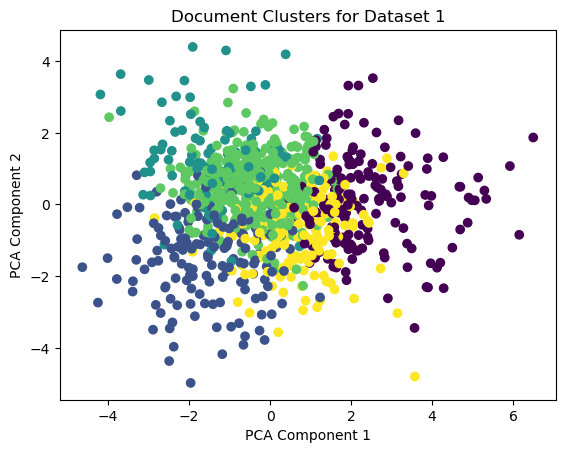

        id                                               text  cluster
0  1781133  it was used in landing craft during world war ...        2
1  2426736  after rejecting an offer from cambridge univer...        1
2  2224122  mat zan coached kuala lumpur fa in 1999 and wo...        0
3   219642  a barcode is a machine readable optical label ...        3
4  1728654  since the subordination of the monarchy under ...        4
        id                                               text  \
0  1781133  it was used in landing craft during world war ...   
1  2426736  after rejecting an offer from cambridge univer...   
2  2224122  mat zan coached kuala lumpur fa in 1999 and wo...   
3   219642  a barcode is a machine readable optical label ...   
4  1728654  since the subordination of the monarchy under ...   

                                          doc_vector  
0  [-0.040734187, 0.5918252, -0.36120984, -1.6931...  
1  [-1.0636848, 2.954792, -1.7097781, 1.4032245, ...  
2  [-2.2786868, -0

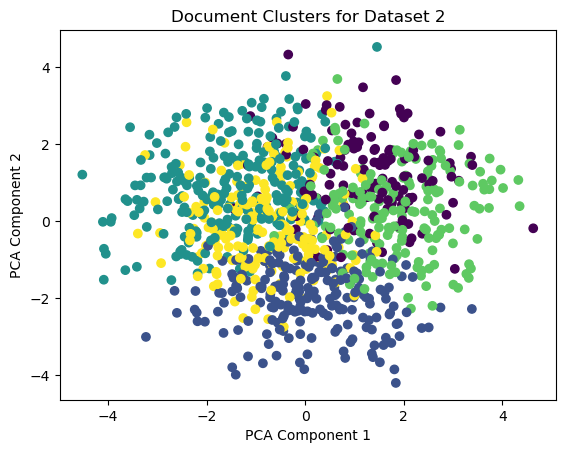

In [5]:
# Function to get document vectors
def get_document_vectors(documents, model):
    for doc in documents:
        doc_vector = model.infer_vector(doc.tokens)
        doc.set_vector(doc_vector)

# Infer vectors for documents
get_document_vectors(documents1, model)
get_document_vectors(documents2, model)

# Function to perform document clustering
def cluster_documents(documents, num_clusters=5):
    doc_vectors = [doc.vector for doc in documents]
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(doc_vectors)
    clusters = kmeans.labels_
    return clusters, kmeans.cluster_centers_

# Cluster the documents for Dataset 1
num_clusters = 5
clusters1, cluster_centers1 = cluster_documents(documents1, num_clusters)

# Add cluster information to DataFrame for Dataset 1
df1['cluster'] = clusters1
print(df1[['id', 'text', 'cluster']].head())

# Add document vectors to DataFrame for easy viewing
df1['doc_vector'] = [doc.vector for doc in documents1]
print(df1[['id', 'text', 'doc_vector']].head())

# Visualize clusters using PCA for Dataset 1
pca = PCA(n_components=2)
reduced_vectors1 = pca.fit_transform([doc.vector for doc in documents1])
plt.scatter(reduced_vectors1[:, 0], reduced_vectors1[:, 1], c=clusters1, cmap='viridis')
plt.title('Document Clusters for Dataset 1')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Cluster the documents for Dataset 2
clusters2, cluster_centers2 = cluster_documents(documents2, num_clusters)

# Add cluster information to DataFrame for Dataset 2
df2['cluster'] = clusters2
print(df2[['id', 'text', 'cluster']].head())

# Add document vectors to DataFrame for easy viewing
df2['doc_vector'] = [doc.vector for doc in documents2]
print(df2[['id', 'text', 'doc_vector']].head())

# Visualize clusters using PCA for Dataset 2
reduced_vectors2 = pca.fit_transform([doc.vector for doc in documents2])
plt.scatter(reduced_vectors2[:, 0], reduced_vectors2[:, 1], c=clusters2, cmap='viridis')
plt.title('Document Clusters for Dataset 2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [6]:
# Display tagged data
print(tagged_data1[:5])
print(tagged_data2[:5])

[TaggedDocument(words=['experience', 'rabbit', 'easy', 'housebreak', 'like', 'pee', 'poop', 'place', 'every', 'time', 'case', 'put', 'little', 'bit', 'waste', 'litter', 'box', 'happily', 'use', 'litter', 'box', 'important', 'go', 'somewhere', 'else', 'miss', 'edge', 'kick', 'waste', 'box', 'clean', 'well', 'immediately', 'otherwise', 'spot', 'become', 'exist', 'place', 'pee', 'poop', 'clean', 'box', 'save', 'little', 'bit', 'waste', 'put', 'clean', 'box', 'smell', 'right', 'foolproof', 'method', 'get', 'piece', 'wood', 'soak', 'urine', 'put', 'box', 'along', 'droppings', 'cage', 'litter', 'box', 'week', 'generally', 'try', 'first', 'method', 'find', 'use', 'box', 'first', 'day', 'go', 'litter', 'box', 'week', 'method', 'wood', 'block', 'work', 'well', 'move', 'hutch', 'outdoors', 'litter', 'box', 'indoors', 'indoor', 'cage', 'use', 'cage', 'litter', 'box', 'attach', 'litter', 'box', 'section', 'cage', 'rabbit', 'use', 'waste', 'sure', 'use', 'clay', 'newsprint', 'litter', 'type', 'aren

In [7]:
# FastAPI integration
from inverted_index import InvertedIndex
from dataset import Datasets
import threading
import requests
from fastapi_app import FastAPIApp

# Initialize datasets and models
datasets = Datasets()

# Assuming you have already defined csv_loader1, csv_loader2, model, strip_chars
inverted_index1 = InvertedIndex(csv_loader1, model, strip_chars, stopwords.words('english'), WordNetLemmatizer())
inverted_index2 = InvertedIndex(csv_loader2, model, strip_chars, stopwords.words('english'), WordNetLemmatizer())

# Assign dataframes to inverted indexes (df1 and df2 should be defined)
inverted_index1.df = df1
inverted_index2.df = df2

# Create a dictionary of datasets
datasets_dict = {
    'dataset1': inverted_index1,
    'dataset2': inverted_index2
}

# Create an instance of the FastAPI app
api_app = FastAPIApp(datasets_dict)

# Run the FastAPI app in a separate thread
threading.Thread(target=api_app.run, args=("127.0.0.1", 8001)).start()

# Function to query the FastAPI app
def query_fastapi(query, dataset_name, top_k=5):
    query_data = {"query": query, "top_k": top_k, "dataset_name": dataset_name}
    response = requests.post("http://127.0.0.1:8001/search", json=query_data)
    try:
        response.raise_for_status()  # Raise an error for bad status codes
        json_response = response.json()  # Parse the JSON response
        print("JSON Response:", json_response)  # Debugging line
        return json_response
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    return None


DataFrame head:
   0  \
0  1   
1  2   
2  3   
3  4   
4  5   

  In my experience rabbits are very easy to housebreak. They like to pee and poop in the same place every time, so in most cases all you have to do is put a little bit of their waste in the litter box and they will happily use the litter box. It is very important that if they go somewhere else, miss the edge or kick waste out of the box that you clean it up well and immediately as otherwise those spots will become existing places to pee and poop. When you clean the box, save a little bit of waste and put it in the cleaned box so it smells right to them. For a more foolproof method, you can get a piece of wood soaked with their urine and put that in the box along with droppings or cage them so that they are only in their litter box for a week. Generally, if I try the first method and find that they are not using only the box on the first day, I go for the litter box only for a week method. The wood block works well if you 

INFO:     Started server process [11539]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


In [8]:
# Example query using FastAPI
query = "rabbits"
dataset_name = "dataset2"
top_k = 5
results = query_fastapi(query, dataset_name, top_k)

# Ensure results is not None and has the correct structure
if results and 'data' in results:
    print("Matched Documents and Scores:")
    for result in results['data']:
        doc_id = result['document_id']
        similarity = result['similarity']
        print(f"Document ID: {doc_id}, Similarity: {similarity}, Text: {result['text']}")
else:
    print("No results found or error in query.")

# Print evaluation metrics
lookup_results = datasets_dict[dataset_name].lookup(query, top_k=top_k)
print("Evaluation Metrics:", lookup_results['evaluation'])

# Function to query the inverted index directly
def query_inverted_index(dataset, query, top_k=5):
    results = dataset.lookup(query, top_k=top_k)
    indices = [result['doc_id'] for result in results['irsResult']]
    distances = [result['doc_similarity'] for result in results['irsResult']]
    return indices, distances

# Query the inverted index
indices, distances = query_inverted_index(datasets_dict[dataset_name], query, top_k)

# Display the results from the inverted index
for idx, dist in zip(indices, distances):
    print(f"Document ID: {idx}, Similarity: {dist}")
    print(f"Document: {datasets_dict[dataset_name].df[datasets_dict[dataset_name].df['id'] == idx]['text'].values[0]}")


INFO:     127.0.0.1:56074 - "POST /search HTTP/1.1" 200 OK
JSON Response: {'data': [{'document_id': 315108, 'similarity': 0.47076454758644104, 'text': 'west asians are typically considered to be white asian latin americans have a centuries long history in the region starting with filipinos in the 16th century the peak of asian immigration occurred in the 19th and 20th centuries however there are currently more than four million asian latin americans nearly 1 of latin america s population chinese and japanese are the group s largest ancestries other major ones include indians koreans and filipinos brazil is home to the largest population of asian latin americans at some 2 2 million the highest ratio of any country in the region is 5 in peru there has been notable emigration from these communities in recent decades so that there are now hundreds of thousands of people of asian latin american origin in both japan and the united states the first asian latin americans were filipinos who mad